In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')
import numpy as np
import json
from drawChiEff import drawChieffs

import sys
sys.path.append('./../code/emceeCode')
from posterior_helper_functions import *

First generate data to plot

In [2]:
# Load data
root = '../data'
models = ['betaPlusMixture', 'betaPlusTruncatedMixture', 'betaSpikePlusMixture', 'betaSpikePlusTruncatedMixture']

eps_min = 0.03

data_dict = {}
for model in models: 
    with open(f'{root}/component_spin_{model}.json', 'r') as f:
        data = json.load(f)
    if model=='betaSpikePlusMixture' or model=='betaSpikePlusTruncatedMixture':
        data_dict[model]= {key:np.asarray(data[key]['processed'])[np.asarray(data['sigma_spike']['processed'])>eps_min] for key in data.keys()}
    else:
        data_dict[model]= {key:np.asarray(data[key]['processed']) for key in data.keys()}

In [3]:
# make dict in which to store data
chieff1s_dict = {}

# cycle through models
for model in models: 
        
    print(f'Calculating chi-eff 1%s for {model}...')
    
    data = data_dict[model]
    idxs = np.arange(len(data['mu_chi']))
        
    chieff1s = np.zeros(len(idxs))
    
    # cycle through downsampled hyper parameters  
    for n,i in enumerate(idxs): 
        
        mu_chi = data_dict[model]['mu_chi'][i]
        sigma_chi = data_dict[model]['sigma_chi'][i]                                
        MF_cost = data_dict[model]['MF_cost'][i]
        sigma_cost = data_dict[model]['sigma_cost'][i]
        Bq = data_dict[model]['Bq'][i]
        
        a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
        
        # specific distribution we calculate depends on the model of interest
        if model=='betaPlusMixture': 
            f_spike = None
            sigma_spike = None
            zmin = -1

        elif model=='betaPlusTruncatedMixture': 
            f_spike = None
            sigma_spike = None
            zmin = data_dict[model]['cost_min'][i]

        elif model=='betaSpikePlusMixture': 
            f_spike = data_dict[model]['frac_in_spike'][i]
            sigma_spike = data_dict[model]['sigma_spike'][i]
            zmin = -1

        elif model=='betaSpikePlusTruncatedMixture':
            f_spike = data_dict[model]['frac_in_spike'][i]
            sigma_spike = data_dict[model]['sigma_spike'][i]
            zmin = data_dict[model]['cost_min'][i]
        
        else: 
            print('model not found, something wrong')
            break    
        
        # draw chi-effectives from this distribution
        chi_effs = drawChieffs(mu_chi, sigma_chi, MF_cost, sigma_cost, f_spike, sigma_spike, zmin, Bq, n=1000)
        
        # calculate 1% quantile on the chi-eff draws 
        chieff1s[i] = np.quantile(chi_effs, 0.01)
        
    # add results to dict
    chieff1s_dict[model] = chieff1s

Calculating chi-eff 1%s for betaPlusMixture...


/home/simona.miller/gwtc3-spin-studies/figures/./../code/emceeCode/posterior_helper_functions.py:257: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


Calculating chi-eff 1%s for betaPlusTruncatedMixture...
Calculating chi-eff 1%s for betaSpikePlusMixture...
Calculating chi-eff 1%s for betaSpikePlusTruncatedMixture...


Then make plot

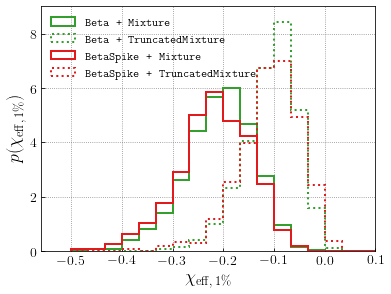

In [4]:
labels = [r'\texttt{Beta + Mixture}', r'\texttt{Beta + TruncatedMixture}', r'\texttt{BetaSpike + Mixture}', r'\texttt{BetaSpike + TruncatedMixture}']
colors=[(51/256,160/256,44/256), (51/256,160/256,44/256), (227/256,26/256,28/256), (227/256,26/256,28/256)]
linestyles=['solid', 'dotted', 'solid', 'dotted']

plt.figure()

for model,label,color,linestyle in zip(models, labels, colors, linestyles):
    
    chieff_mins = chieff1s_dict[model]
    plt.hist(chieff_mins, bins=np.linspace(-0.5,0.3,25), density=True, 
             label=label, histtype='step', color=color, ls=linestyle, lw=2)

plt.xlim(-0.56, 0.1)
plt.ylim(0, 9)
plt.xlabel(r'$\chi_{\mathrm{eff,\,1\%}}$')
plt.ylabel(r'$p(\chi_{\mathrm{eff,\,1\%}})$')
plt.legend(loc='upper left', fontsize=12)

plt.savefig('figure_07.pdf', bbox_inches='tight')

Find percentiles that $\chi_{\mathrm{eff,\,1\%}} > 0$ for the two cases:

In [6]:
for model in models: 
    chieff_mins = chieff1s_dict[model]
    percentile = len(chieff_mins[chieff_mins<0])/len(chieff_mins)
    
    print(model)
    print(percentile)
    print()

betaPlusMixture
1.0

betaPlusTruncatedMixture
0.9963709677419355

betaSpikePlusMixture
1.0

betaSpikePlusTruncatedMixture
0.9875259875259875

